In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

In [ ]:
# Useful Constants

# Those are separate normalized input features for the neural network
INPUT_SIGNAL_TYPES=["body_acc_x_",
                    "body_acc_y_",
                    "body_acc_z_",
                    "body_gyro_x_",
                    "body_gyro_y_",
                    "body_gyro_z_",
                    "total_acc_x_",
                    "total_acc_y_",
                    "total_acc_z_"]

# Output classes to learn how to classify
LABELS=["WALKING",
        "WALKING_UPSTAIRS",
        "WALKING_DOWNSTAIRS",
        "SITTING",
        "STANDING",
        "LAYING"]

## Load Data

In [ ]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

In [ ]:
X_train_signals_paths=["UCI HAR Dataset/train/Inertial Signals/"+signal+"train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths=["UCI HAR Dataset/test/Inertial Signals/"+signal+"test.txt" for signal in INPUT_SIGNAL_TYPES]

X_train=load_X(X_train_signals_paths)
X_test=load_X(X_test_signals_paths)

In [ ]:
y_train_path="UCI HAR Dataset/train/y_train.txt"
y_test_path="UCI HAR Dataset/test/y_test.txt"

y_train=load_y(y_train_path)
y_test=load_y(y_test_path)

In [ ]:
# 7352 training series (with 50% overlap between each series)
# 128 timesteps per series
# 9 input parameters per timestep
print("X_train: "+str(X_train.shape))
print("y_train: "+str(y_train.shape))

# 2947 testing series
# 128 timesteps per series
# 9 input parameters per timestep
print("X_test:  "+str(X_test.shape))
print("y_test:  "+str(y_test.shape))

X_train: (7352, 128, 9)
y_train: (7352, 1)
X_test:  (2947, 128, 9)
y_test:  (2947, 1)


In [ ]:
# one-hot encode to fit multi-class classification model
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

print("y_train: "+str(y_train.shape))
print("y_test:  "+str(y_test.shape))

y_train: (7352, 6)
y_test:  (2947, 6)


In [ ]:
X_train

array([[[ 1.808515e-04,  1.076681e-02,  5.556068e-02, ...,
          1.012817e+00, -1.232167e-01,  1.029341e-01],
        [ 1.013856e-02,  6.579480e-03,  5.512483e-02, ...,
          1.022833e+00, -1.268756e-01,  1.056872e-01],
        [ 9.275574e-03,  8.928878e-03,  4.840473e-02, ...,
          1.022028e+00, -1.240037e-01,  1.021025e-01],
        ...,
        [-1.147484e-03,  1.714439e-04,  2.647864e-03, ...,
          1.018445e+00, -1.240696e-01,  1.003852e-01],
        [-2.222655e-04,  1.574181e-03,  2.381057e-03, ...,
          1.019372e+00, -1.227451e-01,  9.987355e-02],
        [ 1.575500e-03,  3.070189e-03, -2.269757e-03, ...,
          1.021171e+00, -1.213260e-01,  9.498741e-02]],

       [[ 1.093752e-03, -4.687588e-03, -2.685954e-02, ...,
          1.018851e+00, -1.239760e-01,  9.792958e-02],
        [ 4.550077e-03, -7.487894e-03, -2.509841e-02, ...,
          1.022380e+00, -1.268078e-01,  9.935086e-02],
        [ 2.879173e-03, -8.429991e-03, -2.597534e-02, ...,
          1.02

In [ ]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
np.mean(X_train)

0.10206611

In [ ]:
np.std(X_train)

0.40216514

## Fit and Evaluate Model

In [ ]:
# set some additional parameters
n_timesteps=X_train.shape[1]
n_features=X_train.shape[2]
n_outputs=y_train.shape[1]

verbose=1
epochs=15
batch_size=64

In [ ]:
def build_model():
    model=Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
model=build_model()

# fit model
history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=verbose)

# evaluate model
scores=model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

Epoch 1/15
115/115 [==============================] - 11s 83ms/step - loss: 1.2155 - accuracy: 0.4884 - val_loss: 0.9298 - val_accuracy: 0.6390
Epoch 2/15
115/115 [==============================] - 9s 80ms/step - loss: 0.7564 - accuracy: 0.6734 - val_loss: 0.7524 - val_accuracy: 0.7218
Epoch 3/15
115/115 [==============================] - 9s 80ms/step - loss: 0.5928 - accuracy: 0.7643 - val_loss: 0.5866 - val_accuracy: 0.7631
Epoch 4/15
115/115 [==============================] - 9s 81ms/step - loss: 0.4271 - accuracy: 0.8419 - val_loss: 0.4432 - val_accuracy: 0.8459
Epoch 5/15
115/115 [==============================] - 9s 80ms/step - loss: 0.2786 - accuracy: 0.9079 - val_loss: 0.3494 - val_accuracy: 0.8816
Epoch 6/15
115/115 [==============================] - 9s 81ms/step - loss: 0.2513 - accuracy: 0.9101 - val_loss: 0.3618 - val_accuracy: 0.8700
Epoch 7/15
115/115 [==============================] - 9s 80ms/step - loss: 0.2132 - accuracy: 0.9249 - val_loss: 0.2899 - val_accuracy: 0.892

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print(model.metrics_names)
print('test loss', scores[0])
print('test accuracy', scores[1])

['loss', 'accuracy']
test loss 0.26946958899497986
test accuracy 0.9110960364341736


In [ ]:
model.predict(X_test, verbose=1) # default batch_size = 32

93/93 [==============================] - 2s 20ms/step


array([[4.4496256e-04, 6.5878901e-04, 4.1317293e-05, 5.6611352e-02,
        9.4221354e-01, 3.0153864e-05],
       [2.5400129e-04, 3.7459383e-04, 2.1483613e-05, 5.0662298e-02,
        9.4867021e-01, 1.7440487e-05],
       [2.2438299e-04, 3.3067644e-04, 1.8532724e-05, 4.9295098e-02,
        9.5011562e-01, 1.5576514e-05],
       ...,
       [1.9050545e-04, 9.9964476e-01, 1.5692490e-04, 2.5162694e-06,
        4.6744995e-06, 7.3071493e-07],
       [1.8097152e-04, 9.9967432e-01, 1.2540063e-04, 6.1647697e-06,
        1.0517745e-05, 2.5842578e-06],
       [6.0092341e-05, 9.9988854e-01, 3.9189967e-05, 3.7008770e-06,
        5.7718385e-06, 2.7241492e-06]], dtype=float32)

## Plot Learning Curves

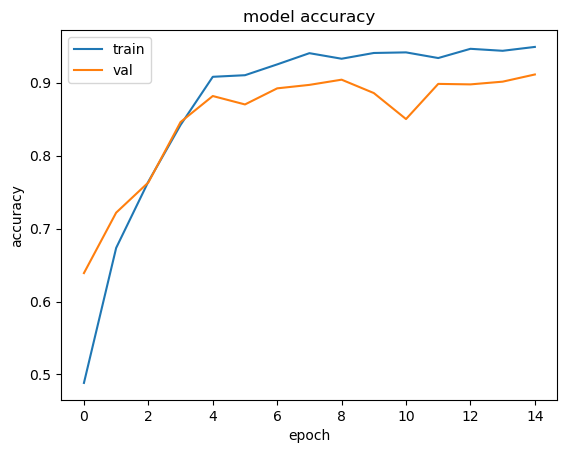

In [ ]:
# plot the accuracy of training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

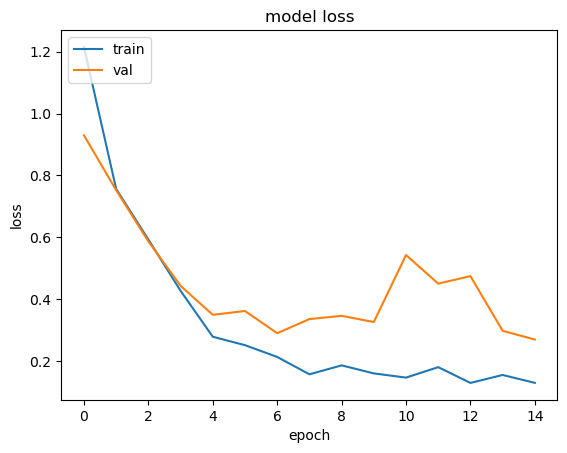

In [ ]:
# plot the loss of training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()